<a href="https://colab.research.google.com/github/AndreyBarTF/turbines_autumn_2022-Homework/blob/Kursach/%D0%9F%D1%83%D0%BD%D0%BA%D1%82_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   ФИО Барбашин Андрей Алексеевич
*   Группа ТФэ-01-20
*   Тлеграмм @QwertyAlexx

In [ ]:
!pip install iapws

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iapws: filename=iapws-1.5.3-py3-none-any.whl size=114282 sha256=d4d6d4fa952aef592050aa4f079c3903a875cc41d99ed8636ff6f02026856d65
  Stored in directory: /root/.cache/pip/wheels/54/ba/11/fdea0d216e8fb4c2e8e112cd6f9032ec3ff199b073973e1960
Successfully built iapws


# Вариант №1
Дано:
* Тип турбины: К-800-23,5 ЛМЗ;
* P0 = 25 МПа; t0 = 560 C; Pпп = 3,63 МПа; tпп = 565 С; Pк = 3,5 кПа; 
tпв = 269 C; Nэ = 830 МВт; z = 9 шт; dр.с. = 0,9-1,1 м; n = 50 (1/c); H0 = 105 кДж/кг












1. Построить процесс расширения пара в турбине. Определение расходов пара на 
входе в турбину (G0) и в конденсатор (Gк).

Массовый расход в турбину на входе 646.008
Массовый расход в конденсатор: 432.268


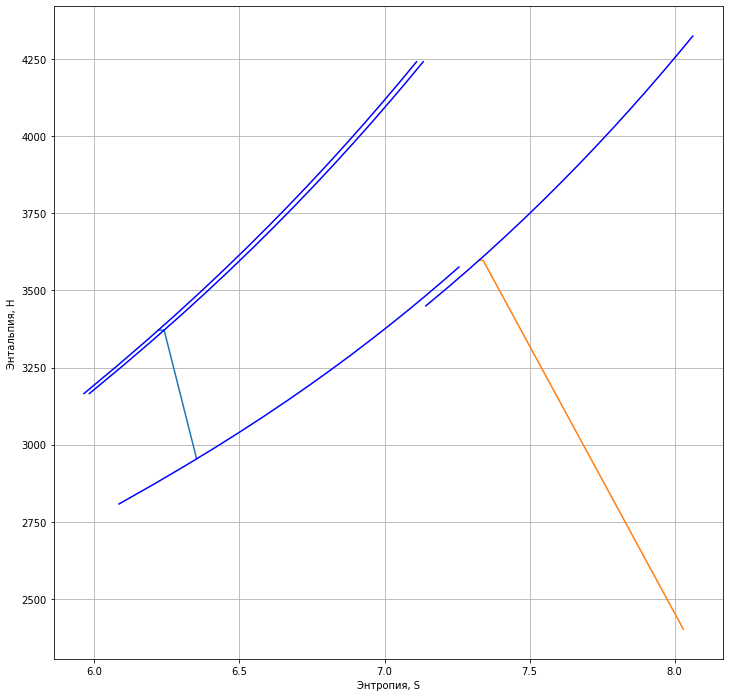

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import iapws
from iapws import IAPWS97 as gas

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

#Исходные данные
#Тип турбины К-800-23,5 ЛМЗ

p_0 = 25 * MPa #Начальное давление
t_0 = 560 #Начальная температура
p_middle = 3.62 * MPa #Давление промперегрева
t_middle = 565 #Температура промперегрева
p_k = 3.5 * kPa #Давление в конденсаторе
t_feed_water = 269 #Температура питательной воды
electrical_power = 830 * (10 ** 6) #Электричесская мощность
z = 9 #Число отборов шт.
avg_diameter = 0.9 # dр.с. = 0,9 - 1,1
rotation_speed = 50 #n
H_0 = 105
p_feed_water = 1.35 * p_0 #Давление питательной воды

#КПД
internal_efficiency = 0.85
mechanical_efficiency = 0.994
generator_efficiency = 0.99

#Потери давления
delta_p0 = 0.05 * p_0
delta_p_middle = 0.1 * p_middle
delta_p_1 = 0.03 * p_middle


real_p0 = p_0 - delta_p0
real_p1t = p_middle + delta_p_middle
real_p_middle = p_middle - delta_p_1

_point_0 = gas(P = p_0 * unit, T=to_kelvin(t_0))
point_0 = gas(P=real_p0 * unit, h=_point_0.h)
point_1t = gas(P=real_p1t * unit, s=_point_0.s)

hp_heat_drop = (_point_0.h - point_1t.h) * internal_efficiency
h_1 = point_0.h - hp_heat_drop
point_1 = gas(P=real_p1t * unit, h=h_1)

_point_middle = gas(P=p_middle * unit, T=to_kelvin(t_middle))
point_middle = gas(P=real_p_middle * unit, h=_point_middle.h)
point_2t = gas(P=p_k * unit, s=_point_middle.s)

lp_heat_drop = (_point_middle.h - point_2t.h) * internal_efficiency
h_2 = point_middle.h - lp_heat_drop
point_2 = gas(P=p_k * unit, h=h_2)

efficiency_hp = (_point_0.h - point_1.h) / (_point_0.h - point_1t.h)
efficiency_lp = (_point_middle.h - point_2.h) / (_point_middle.h - point_2t.h)
efficiency_hp, efficiency_lp

point_k_water = gas(P=p_k * unit, x=0)

point_feed_water = gas(P=p_feed_water * unit, T=to_kelvin(t_feed_water))

numenator_without = point_2.T * (_point_middle.s - point_k_water.s)
denumenator_without = (point_0.h - point_1t.h) + (point_middle.h - point_k_water.h)
without_part = 1 - (numenator_without / denumenator_without)

numenator_infinity = point_2.T * (_point_middle.s - point_feed_water.s)
denumenator_infinity = (point_0.h - point_1t.h) + (point_middle.h - point_feed_water.h)
infinity_part = 1 - (numenator_infinity / denumenator_infinity)

ksi_infinity = 1 - (without_part / infinity_part)

coeff = (point_feed_water.T - point_2.T) / (to_kelvin(374.2) - point_2.T)

ksi = 0.83 * ksi_infinity

#КПД
eff_num = hp_heat_drop + lp_heat_drop
eff_denum = hp_heat_drop + (point_middle.h - point_k_water.h)

efficiency = (eff_num / eff_denum) * (1 / (1 - ksi))

estimated_heat_drop = efficiency * ((point_0.h - point_feed_water.h) + (point_middle.h - point_1.h))

#Массовый расход в турбину на входе
inlet_mass_flow = electrical_power / (estimated_heat_drop * 1000 * mechanical_efficiency * generator_efficiency)

#Массовый расход в конденсатор
condenser_mass_flow = (
    electrical_power /
    ((point_2.h - point_k_water.h) * 1000 * mechanical_efficiency * generator_efficiency) * ((1 / efficiency) - 1)
)

print("Массовый расход в турбину на входе", round(inlet_mass_flow, 3))
print("Массовый расход в конденсатор:", round(condenser_mass_flow, 3))

#Построение процесса расширения в турбине 
t0 = np.arange(500,900,25)
t_00 = list(map(to_kelvin,t0))

#_point_0
points_s = [] 
points_h = []
for temp in t_00:
  points_s.append(gas(P = p_0 * unit, T=temp).s)
  points_h.append(gas(P = p_0 * unit, T=temp).h)
#point_0
points_0s = []
points_0h = []
for value in points_h:
  points_0s.append(gas(P=real_p0 * unit, h=value).s)
  points_0h.append(gas(P=real_p0 * unit, h=value).h)
#point_1
point_1s = []
point_1h = []
point_1th =[]
hp_heat_drop_ = []
h_1_ = []
for index in range(len(points_s)):
  point_1th.append(gas(P=real_p1t * unit, s=points_s[index]).h)
  hp_heat_drop_.append((points_h[index] - point_1th[index]) * internal_efficiency)
  h_1_.append(points_0h[index] - hp_heat_drop_[index])
  point_1s.append(gas(P=real_p1t * unit, h=h_1_[index]).s)
  point_1h.append(gas(P=real_p1t * unit, h=h_1_[index]).h)

#_point_middle
_point_middle_s = [] 
_point_middle_h = []
for value in t_00:
  _point_middle_s.append(gas(P=p_middle * unit, T=value).s)
  _point_middle_h.append(gas(P=p_middle * unit, T=value).h)

#point_middle = gas(P=real_p_middle * unit, h=_point_middle.h)


fig, ax = plt.subplots()
X1 = [_point_0.s,point_0.s,point_1.s]
Y1 = [_point_0.h,point_0.h,point_1.h]
Z1 = points_s #X
Z2 = points_h #Y
Z3 = points_0s
Z4 = points_0h
Z5 = point_1s
Z6 = point_1h
X2 = [_point_middle.s,point_middle.s,point_2.s]
Y2 = [_point_middle.h,point_middle.h,point_2.h]
Z11 = _point_middle_s
Z22 = _point_middle_h
plt.xlabel("Энтропия, S")
plt.ylabel("Энтальпия, H")
plt.plot(X1, Y1)
plt.plot(X2, Y2)
plt.plot(Z1, Z2, color="blue")
plt.plot(Z3, Z4, color="blue")
plt.plot(Z5, Z6, color="blue")
plt.plot(Z11, Z22, color="blue")
plt.grid()
fig.set_figwidth(12)    #  ширина и
fig.set_figheight(12)    #  высота "Figure"
plt.show()